# Laboratorio 04
## U-net y filtros anisotrópicos
- Ricardo Mendez 21289
- Sara Echeverría 21371
- Melissa Pérez 21385

Repositorio: https://github.com/MelissaPerez09/Lab04-CC3102

### Acerca de los filtros anisotrópicos:
Son técnicas de procesamiento de imágenes que reducen ruido, destacan por mantener los bordes y estructuras relevantes de la imagen. A diferencia de otros filtros, como Guassian Blur, los anisotrópicos se adaptan localmente al contenido para evitar desenfocar en detalles importantes de la imagen.

El filtro de Perona-Malik funciona con un proceso de difusión controlada donde reducen el efecto de difusión cuando el gradiente es alto. Entonces dependiendo del tamaño del gradiente es la forma en que suaviza o preserva la estructura.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
from Anisotropic import anisodiff
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [2]:
#load images
imagenes_paths = glob.glob("./img/*.jpg")

imagenes = []
target_size = (256, 256)

for path in imagenes_paths:
    img = Image.open(path).convert("L")
    img = img.resize(target_size)
    imagenes.append(np.array(img))

stack = np.stack(imagenes)

In [3]:
print(stack.shape)

(25, 256, 256)


In [ ]:
# difuse the image
img_diffused = anisodiff(stack, niter=15, kappa=30, gamma=0.2, option=1)

/Users/melissa/Desktop/UVG/2025/vc/Lab04-CC3102/src/Anisotropic.py:65: UserWarning: Only grayscale images allowed, converting to 2D matrix
  warnings.warn("Only grayscale images allowed, converting to 2D matrix")


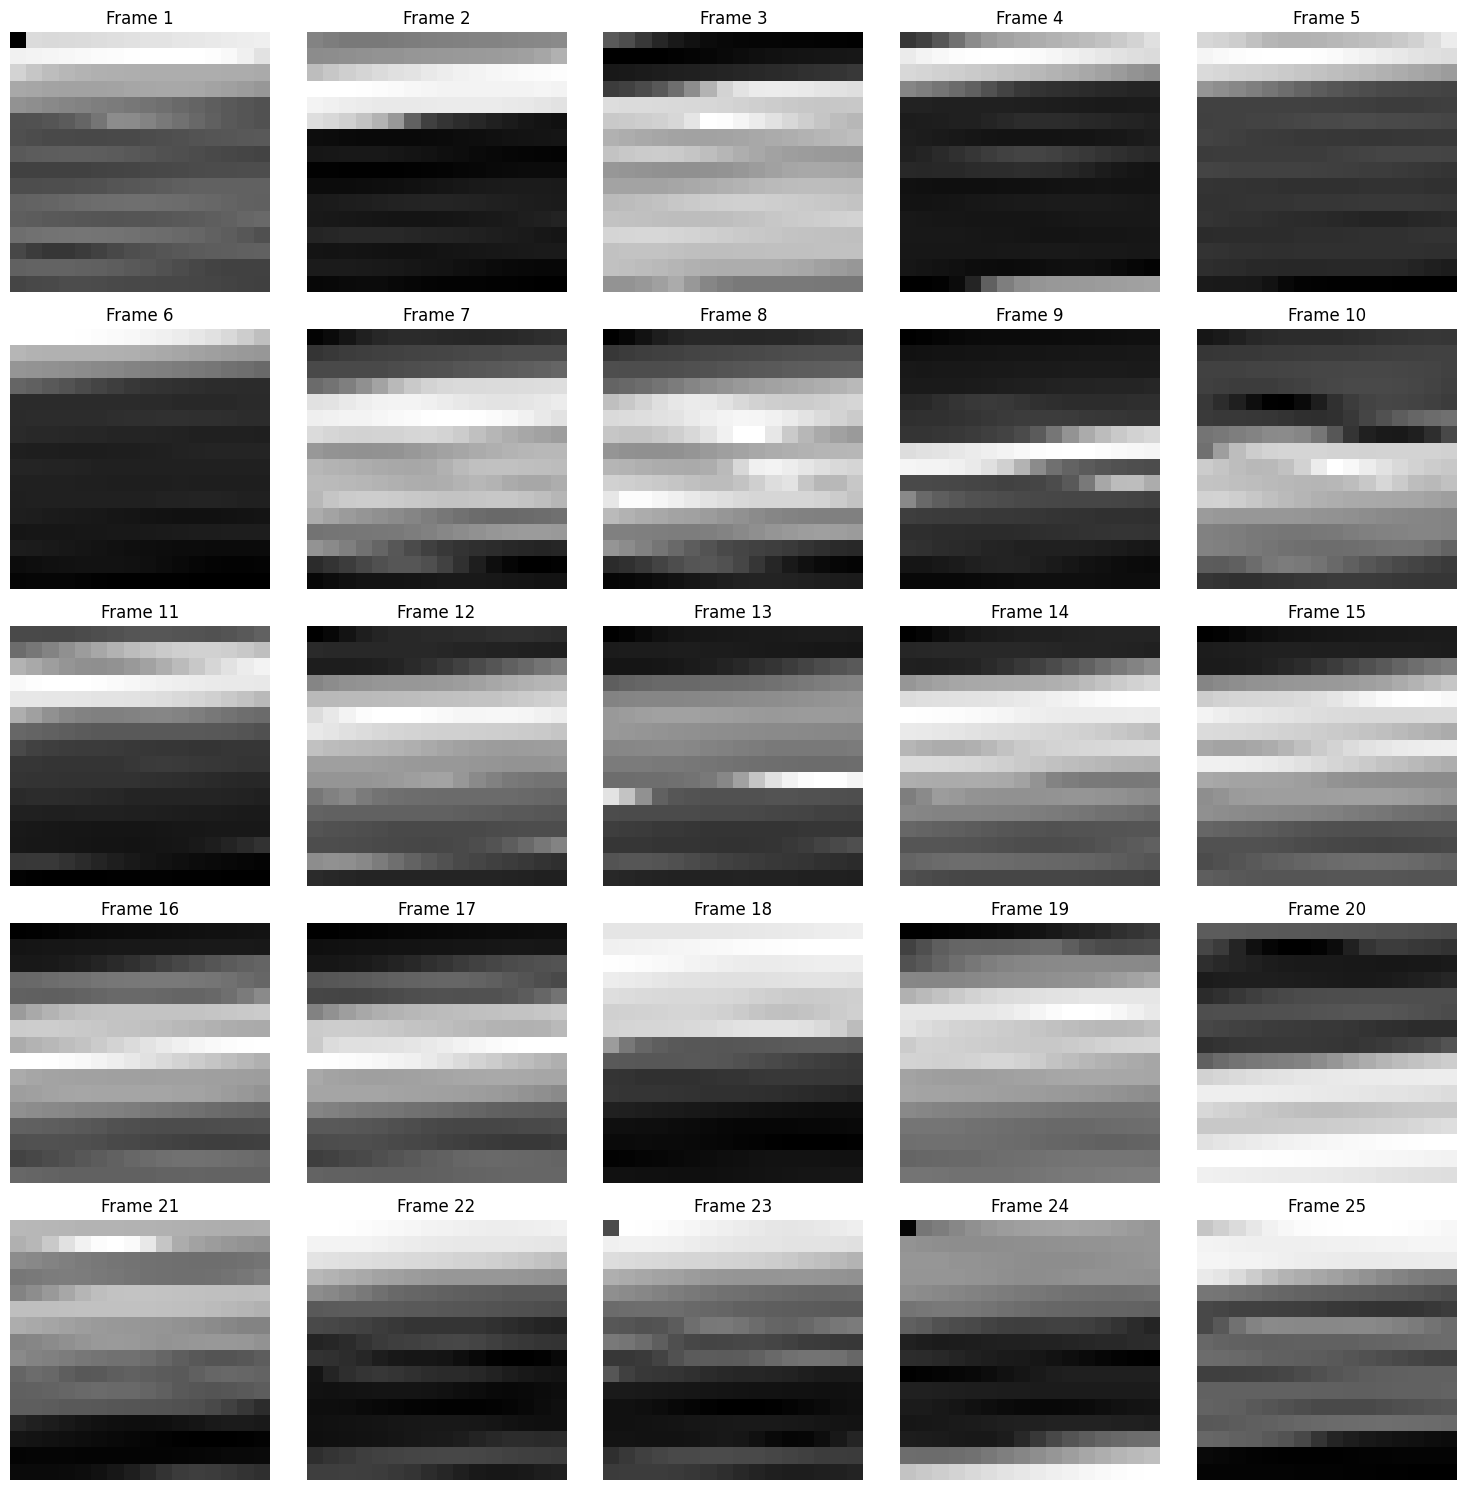

In [5]:
#muestra por frames la imagen difusa
num_frames = img_diffused.shape[0]
cols = 5
rows = (num_frames + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i in range(num_frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_diffused[i].reshape(16, 16), cmap='gray')
    plt.axis('off')
    plt.title(f"Frame {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
#funcion para generar la coleccion de muestras
def extraer_patches(imagenes_originales, imagenes_filtradas, k=32, N=500000):

    X = np.zeros((N, k, k, 1), dtype=np.float32)
    Y = np.zeros((N, k, k, 1), dtype=np.float32)

    num_imagenes = len(imagenes_originales)

    for i in range(N):
        idx_img = np.random.randint(0, num_imagenes)

        img_orig = imagenes_originales[idx_img]
        img_filt = imagenes_filtradas[idx_img]

        H, W = img_orig.shape

        #posicion aleatoria
        x = np.random.randint(0, W - k + 1)
        y = np.random.randint(0, H - k + 1)

        #extraer patches
        patch_orig = img_orig[y:y+k, x:x+k]
        patch_filt = img_filt[y:y+k, x:x+k]

        X[i, :, :, 0] = patch_orig
        Y[i, :, :, 0] = patch_filt

    return X, Y

In [ ]:
imagenes_filtradas = []
for img in imagenes:
    filtrada = anisodiff(img, niter=15, kappa=30, gamma=0.2, option=1)
    imagenes_filtradas.append(filtrada)

imagenes_filtradas = [img.astype(np.float32) for img in imagenes_filtradas]

In [8]:
# extraer patches de las imágenes originales y filtradas
X, Y = extraer_patches(imagenes, imagenes_filtradas, k=32, N=500000)

# division de entrenamiento y prueba (80% - 20%)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# division de entrenamiento y validacion
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=42)

# Verificación
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (300000, 32, 32, 1)
X_val: (100000, 32, 32, 1)
X_test: (100000, 32, 32, 1)


### U-net

In [11]:
def DownBlock(X, filters, drop_p=0.0, module_name=''):
    x = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu', name=module_name+'_Conv1')(X)
    x = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu', name=module_name+'_Conv2')(x)
    x = MaxPooling2D(pool_size=(2,2), name=module_name+'_MaxPool')(x)
    x = Dropout(drop_p, name=module_name+'_Dropout')(x)
    return x

In [12]:
def UpBlock(X, Y, filters, drop_p=0.0, module_name=''):
    x = UpSampling2D(size=(2,2), interpolation='bilinear', name=module_name+'_UpSample')(X)
    x = Concatenate(name=module_name+'_Concat')([x, Y])
    x = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu', name=module_name+'_Conv1')(x)
    x = Conv2D(filters, kernel_size=(3,3), padding='same', activation='relu', name=module_name+'_Conv2')(x)
    x = Dropout(drop_p, name=module_name+'_Dropout')(x)
    return x

In [ ]:
#red neuronal UNet
def UNet(input_shape, levels=5, filters=16, drop_p=0.1):
    X0 = Input(shape=input_shape, name='input')

    X1 = DownBlock(X0, filters,   drop_p, module_name='Down1')
    X2 = DownBlock(X1, filters*2, drop_p, module_name='Down2')
    X3 = DownBlock(X2, filters*4, drop_p, module_name='Down3')
    X4 = DownBlock(X3, filters*8, drop_p, module_name='Down4')

    Y3 = UpBlock(X4, X3, filters*4, drop_p, module_name='Up4')
    Y2 = UpBlock(Y3, X2, filters*2, drop_p, module_name='Up3')
    Y1 = UpBlock(Y2, X1, filters,   drop_p, module_name='Up2')
    Y0 = UpBlock(Y1, X0, filters,   drop_p, module_name='Up1')

    Z = Conv2D(1, kernel_size=(1,1), padding='same', activation='relu', name='Tail')(Y0)

    model = Model(X0, Z, name='Unet')
    return model

In [18]:
input_shape = (32, 32, 1)
model = UNet(input_shape=input_shape)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, Y_train, 
                    validation_data=(X_val, Y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 415s 44ms/step - loss: 331.0987 - mae: 12.2203 - val_loss: 15.6583 - val_mae: 2.2786
Epoch 2/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 420s 45ms/step - loss: 197.4534 - mae: 10.0543 - val_loss: 13.5569 - val_mae: 2.2389
Epoch 3/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 414s 44ms/step - loss: 168.7784 - mae: 9.0648 - val_loss: 13.4995 - val_mae: 2.2868
Epoch 4/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 422s 45ms/step - loss: 145.2455 - mae: 8.1783 - val_loss: 14.0791 - val_mae: 2.4741
Epoch 5/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 421s 45ms/step - loss: 126.1651 - mae: 7.4226 - val_loss: 13.9089 - val_mae: 2.4115
Epoch 6/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 412s 44ms/step - loss: 109.9758 - mae: 6.7816 - val_loss: 13.1192 - val_mae: 2.3388
Epoch 7/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 408s 44ms/step - loss: 96.2543 - mae: 6.2427 - val_loss: 12.6810 - val_mae: 2.2740
Epoch 8/10
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 416s 44ms/step - loss: 85.7606 - mae: 5.8403 - val_loss: 11.4214 - val_mae:

In [19]:
model.save("unet_model.h5")

In [11]:
model = load_model("unet_model.h5")

In [12]:
model.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 32, 32, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down1_Conv1         │ (None, 32, 32,    │        160 │ input[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down1_Conv2         │ (None, 32, 32,    │      2,320 │ Down1_Conv1[0][0] │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down1_MaxPool       │ (None, 16, 16,    │          0 │ Down1_Conv2[0][0] │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down1_Dropout       │ (None, 16, 16,    │          0 │ Down1_MaxPool[0]… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down2_Conv1         │ (None, 16, 16,    │      4,640 │ Down1_Dropout[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down2_Conv2         │ (None, 16, 16,    │      9,248 │ Down2_Conv1[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down2_MaxPool       │ (None, 8, 8, 32)  │          0 │ Down2_Conv2[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down2_Dropout       │ (None, 8, 8, 32)  │          0 │ Down2_MaxPool[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down3_Conv1         │ (None, 8, 8, 64)  │     18,496 │ Down2_Dropout[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down3_Conv2         │ (None, 8, 8, 64)  │     36,928 │ Down3_Conv1[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down3_MaxPool       │ (None, 4, 4, 64)  │          0 │ Down3_Conv2[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down3_Dropout       │ (None, 4, 4, 64)  │          0 │ Down3_MaxPool[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down4_Conv1         │ (None, 4, 4, 128) │     73,856 │ Down3_Dropout[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down4_Conv2         │ (None, 4, 4, 128) │    147,584 │ Down4_Conv1[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down4_MaxPool       │ (None, 2, 2, 128) │          0 │ Down4_Conv2[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down4_Dropout       │ (None, 2, 2, 128) │          0 │ Down4_MaxPool[0]… │
│ (Dropout)           │                   │            │                 

 Total params: 491,795 (1.88 MB)

 Trainable params: 491,793 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
def inference(model, imagen_test, k=32, paso=8):
    H, W = imagen_test.shape

    suma_predicciones = np.zeros((H, W), dtype=np.float32)
    conteo = np.zeros((H, W), dtype=np.float32)

    for y in range(0, H - k + 1, paso):
        for x in range(0, W - k + 1, paso):
            ventana = imagen_test[y:y+k, x:x+k]
            ventana_input = ventana.reshape(1, k, k, 1).astype(np.float32)
            pred = model.predict(ventana_input, verbose=0)[0, :, :, 0]

            suma_predicciones[y:y+k, x:x+k] += pred
            conteo[y:y+k, x:x+k] += 1

    conteo[conteo == 0] = 1
    imagen_reconstruida = suma_predicciones / conteo

    return imagen_reconstruida

In [17]:
#lista para resultados
resultados_filtrados = []

#se aplica la inferencia a todas las imagenes
for i, img in enumerate(imagenes):
    print(f"Inferiendo imagen {i+1}/{len(imagenes)}...")
    resultado = inference(model, img.astype(np.float32), k=32)
    resultados_filtrados.append(resultado)

Inferiendo imagen 1/25...
Inferiendo imagen 2/25...
Inferiendo imagen 3/25...
Inferiendo imagen 4/25...
Inferiendo imagen 5/25...
Inferiendo imagen 6/25...
Inferiendo imagen 7/25...
Inferiendo imagen 8/25...
Inferiendo imagen 9/25...
Inferiendo imagen 10/25...
Inferiendo imagen 11/25...
Inferiendo imagen 12/25...
Inferiendo imagen 13/25...
Inferiendo imagen 14/25...
Inferiendo imagen 15/25...
Inferiendo imagen 16/25...
Inferiendo imagen 17/25...
Inferiendo imagen 18/25...
Inferiendo imagen 19/25...
Inferiendo imagen 20/25...
Inferiendo imagen 21/25...
Inferiendo imagen 22/25...
Inferiendo imagen 23/25...
Inferiendo imagen 24/25...
Inferiendo imagen 25/25...


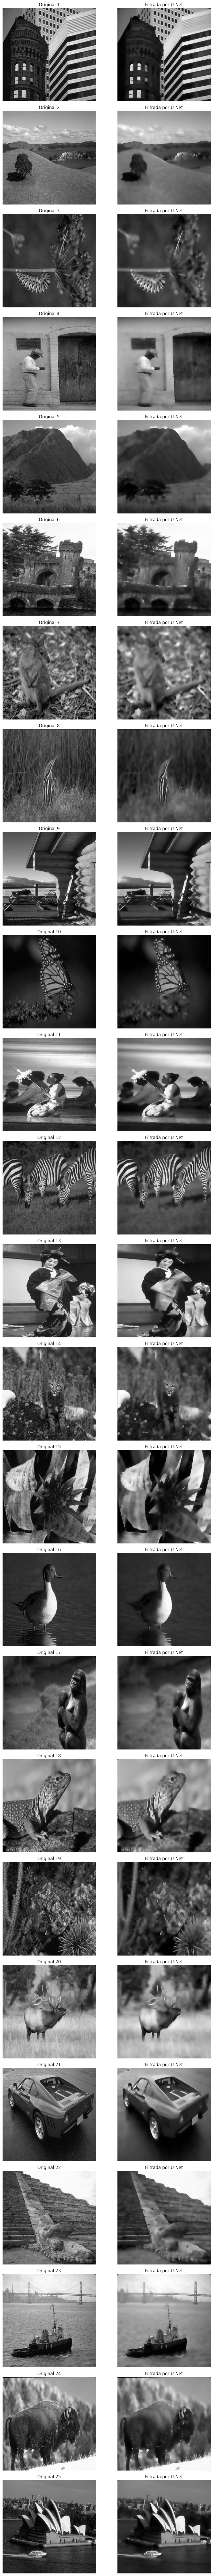

In [18]:
# Visualización
num_imgs = len(imagenes)
cols = 2
rows = num_imgs

plt.figure(figsize=(10, 4 * rows))

for i in range(num_imgs):
    plt.subplot(rows, cols, 2 * i + 1)
    plt.imshow(imagenes[i], cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(rows, cols, 2 * i + 2)
    plt.imshow(resultados_filtrados[i], cmap='gray')
    plt.title(f"Filtrada por U-Net")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Discusión de resultados
Basado en los resultados obtenidos y en la comparación visual entre la imagen original con la imagen filtrad, pueden evidenciarse los siguientes aspectos:
- En varias imágenes se nota una reducción de ruido leve, lo que indica que la U-Net aprendió a suavizar sin destruir detalles ensenciales. 
- En imágenes como la cebra(12) o el edificio(01), los bordes aún están definidos a pesar de estar difusos. Lo que indica que aprendió la lógica del filtro.
- Se notan texturas más limpias, como en la imagen del barco(23) donde el cielo tiene mejor suavidad.

Por otro lado, algunas áreas de mejora serían:
-  Al existir en algunas imágenes cambios leves, podría entrenarse con más épocas y datos porque el modelo puede estar necesitando más entrenamiento para poder generalizar lo suficiente.